<a href="https://colab.research.google.com/github/saarzeev/DeepLearningWorkShopHW1/blob/master/deepLearningWorkShopHW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, AvgPool2D, MaxPool2D, Dropout, MaxPooling2D, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.applications import vgg16
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import misc
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1.a+b

We have chosen the[ plant pathology](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview) dataset. While the contest is still active, current top-50 submissions achieved accuracy higher than 98%.

The size of the dataset is 780MB. There are 3642 photos. 1812 for train, 1812 for test.
Each photo is 2048X1365 pixels and has 3 channels. The photos are of leaves and are ready to use - we may try augmenations on it for better results. The pictures can be classified to 1 from 4 classes:
healthy, multiple_diseases, rust, scab

number of train files: 1821
number of test files: 1821
4 class labels: ['healthy', 'multiple_diseases', 'rust', 'scab']
picture dimensions: (1365, 2048, 3)
image example:


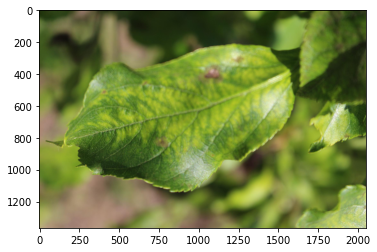

In [3]:
folder='/content/drive/My Drive/Colab Notebooks/' 

train_files=pd.read_csv(folder+'train.csv',engine="python")
test_files=pd.read_csv(folder+'test.csv',engine="python")

print("number of train files: "+str(len(train_files)))
print("number of test files: "+str(len(test_files)))

labels=list(train_files.columns)
labels.remove('image_id')
print(str(len(labels))+' class labels: '+str(labels))

print('picture dimensions: '+str(img_to_array(load_img(folder+'images/Train_0.jpg')).shape))

print('image example:')
img=load_img(folder+'images/Train_0.jpg')
imgplot = plt.imshow(img)
plt.show()

helpful functions for later

In [0]:
def get_label(row):
  if row['healthy']==1:
    return 'healthy'
  if row['multiple_diseases']==1:
    return 'multiple_diseases'
  if row['rust']==1:
    return 'rust'
  if row['scab']==1:
    return 'scab'

def read_and_flatten_single_img(filename):
    arr = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2GRAY)
    arr = cv2.resize(arr,dsize=(32,32))
    arr= np.array(arr).reshape(1,1024)
    return arr

def get_image(path):
  return load_img(path)

def class_to_number(class_name):
  if 'healthy'==class_name:
    return 0
  if 'multiple_diseases'==class_name:
    return 1
  if 'rust'==class_name:
    return 2
  if 'scab'==class_name:
    return 3

def compute_confusion_matrix(model, validation_generator=None):
  if not validation_generator:
    validation_generator = datagen.flow_from_dataframe(
      Validation, 
      x_col='X',
      y_col= 'y',
      target_size=(224,224),
      class_mode='categorical',
      shuffle=False,
      batch_size=batch_size
  )
  preds = model.predict(validation_generator)
  pred_cat = np.argmax(preds,axis=1)
  y_val_in_numbers=y_val.apply(class_to_number)
  print('model accuracy on test set is: {0:.2f}%'.format(accuracy_score(y_val_in_numbers,pred_cat)*100))
  sns.heatmap(confusion_matrix(y_val_in_numbers,pred_cat),cmap='Greens',annot=True, fmt='d')
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('validation results:')

def train_and_print(model, epochs=10):
  np.random.seed(2020)
  hist=model.fit_generator(train_generator,validation_data=validation_generator,steps_per_epoch=len(Train)//batch_size,
                     validation_steps=len(Validation)//batch_size,epochs=epochs,shuffle=True)
  #  "Accuracy"
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  
def prediction_on_sample(model,validationgenerator):
  predictions_from_model=model.predict(validationgenerator)
  pred_cat = np.argmax(predictions_from_model,axis=1)
  classes=['healthy', 'multiple_diseases', 'rust', 'scab']

  #find images
  highProbability=[]
  lowProbability=[]
  for index in range(len(predictions_from_model)):
    if max(predictions_from_model[index])>0.99:
      highProbability.append((index,predictions_from_model[index]))
    elif max(predictions_from_model[index])<0.5:
      lowProbability.append((index,predictions_from_model[index]))

  #print images
  for tup in highProbability[:3]:
    expected=Validation['y'][tup[0]];
    actual=classes[np.argmax(tup[1])];
    print('high probability: expected '+expected+' and got '+actual)
    img=load_img(Validation['X'][tup[0]])
    imgplot = plt.imshow(img)
    plt.show()
  for tup in lowProbability[:3]:
    expected=Validation['y'][tup[0]];
    actual=classes[np.argmax(tup[1])];
    print('low probability: expected '+expected+' and got '+actual)
    img=load_img(Validation['X'][tup[0]])
    imgplot = plt.imshow(img)
    plt.show()

creating split datasets:

In [0]:
X=train_files[['image_id']].apply(lambda name: folder+'images/'+name+'.jpg').rename(columns={'image_id':'X'})
y=train_files.apply(get_label,axis=1).rename('y')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

Train = pd.concat([X_train, y_train], axis=1, sort=False).reset_index(drop=True)
Validation= pd.concat([X_val, y_val], axis=1, sort=False).reset_index(drop=True)

In [0]:
print(X_train.X.shape)

(1638,)


## 1.c
We will count the number of instances of each class. We can see that the dataset is imbalanced. One of our labels 'multiple_diseases' is not as common as others. Since having multiple diseases in the same time is quite rare and as long as we find at least one of the diseases we will allow it for now- but we may need to make adjustments if the results we are expecting aren't met.

class healthy has 516 instances
class multiple_diseases has 91 instances
class rust has 622 instances
class scab has 592 instances


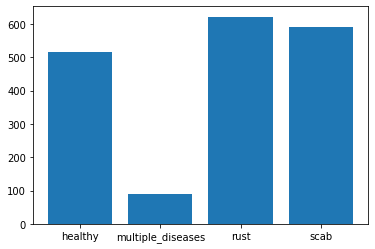

In [0]:
plot_x=[]
plot_y=[]
for col in train_files:
  if col!='image_id':
    plot_x.append(col)
    plot_y.append(train_files[col].sum())
    print('class '+col+' has '+str(train_files[col].sum())+' instances')

plt.bar(plot_x,plot_y)
plt.show()

## 1.d
benchmark results. Current top-50 submissions achieved accuracy higher than 98% mostly built on transfer learning models. In a logistic regression method we got the following results. We see that logistic regression cannot generalize as much as we need 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


model accuracy on validation set is: 26.775956284153008%


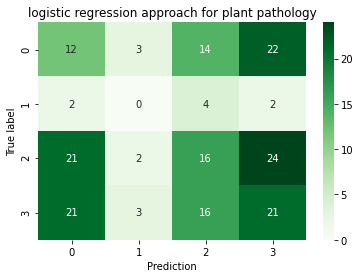

In [0]:
lrc_train_X=np.array(list(X_train['X'].apply(lambda path: read_and_flatten_single_img(path)).values)).reshape(len(X_train['X']),1024)
lrc_train_y=Train['y'].apply(class_to_number)
lrc_val_X=np.array(list(X_val['X'].apply(lambda path: read_and_flatten_single_img(path)).values)).reshape(len(X_val['X']),1024)
lrc_val_y=Validation['y'].apply(class_to_number)

#run model
lrc = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=400)
lrc.fit(lrc_train_X,lrc_train_y)
#evalute model
preds = lrc.predict(lrc_val_X)
pred_cat = preds
print('model accuracy on validation set is: {}%'.format(accuracy_score(lrc_val_y,pred_cat)*100))
sns.heatmap(confusion_matrix(lrc_val_y,pred_cat),cmap='Greens',annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('logistic regression approach for plant pathology')
plt.show()

## 1.e sample of the dataset

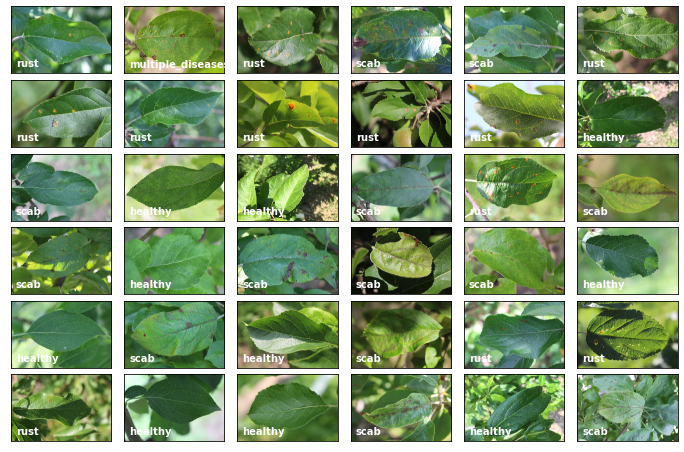

In [0]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='white',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='white',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()

#showing the samples
sample_files=Train.head(50)
x_sample=sample_files['X'].apply(get_image).reset_index(drop=True)
y_sample=sample_files['y'].reset_index(drop=True)
plot_multiple_imgs(x_sample,y_sample,6,6,(12,8))

From the pictures we can conclude that data augmentation techniques can be applied, e.g. horizontal and vertical flips, zoom, width and height shift, brightness changes, and rotation.

In terms of preprocessing, we will need to rescale the pixel values to the range [0,1], to match the range of the relu activation function.

# 2

# 2.a
We will use a train-test-split. While k-fold cross validation offers a more representative performance score, 


In [0]:
batch_size=32
datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=False
)

train_generator = datagen.flow_from_dataframe(
    Train, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    class_mode='categorical',
    batch_size=batch_size
)
validation_generator = datagen.flow_from_dataframe(
    Validation, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    class_mode='categorical',
    batch_size=batch_size
)

Found 1638 validated image filenames belonging to 4 classes.
Found 183 validated image filenames belonging to 4 classes.


# 2.b

In [0]:
inp = Input((224,224,3))
x = Conv2D(16,(3,3),activation='relu',)(inp)
x = Conv2D(16,(3,3),activation='relu')(x)
x = Dropout(0.1)(x)
x = MaxPool2D()(x)
x = Conv2D(32,(3,3),activation='relu')(x)
x = Conv2D(32,(3,3),activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(4,activation='softmax')(x)

model = Model(inputs=inp,outputs=x)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 32)      9248

Epoch 1/10
51/51 [==============================] - 64s 1s/step - loss: 1.2469 - accuracy: 0.3898 - val_loss: 1.1722 - val_accuracy: 0.4313
Epoch 2/10
51/51 [==============================] - 67s 1s/step - loss: 1.1601 - accuracy: 0.4527 - val_loss: 1.1011 - val_accuracy: 0.4503
Epoch 3/10
51/51 [==============================] - 63s 1s/step - loss: 1.0660 - accuracy: 0.5417 - val_loss: 1.0708 - val_accuracy: 0.4503
Epoch 4/10
51/51 [==============================] - 61s 1s/step - loss: 0.9481 - accuracy: 0.5953 - val_loss: 1.0168 - val_accuracy: 0.5033
Epoch 5/10
51/51 [==============================] - 60s 1s/step - loss: 0.6317 - accuracy: 0.7379 - val_loss: 1.2875 - val_accuracy: 0.4768
Epoch 6/10
51/51 [==============================] - 61s 1s/step - loss: 0.3166 - accuracy: 0.8873 - val_loss: 1.7942 - val_accuracy: 0.4238
Epoch 7/10
51/51 [==============================] - 61s 1s/step - loss: 0.1206 - accuracy: 0.9626 - val_loss: 1.5139 - val_accuracy: 0.5250
Epoch 8/10
51/51 [==

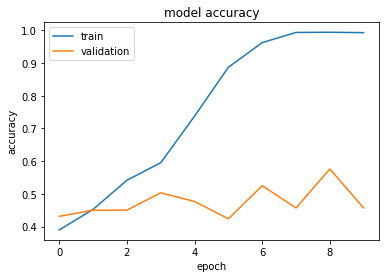

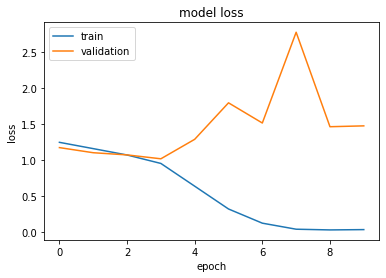

Found 183 validated image filenames belonging to 4 classes.
model accuracy on test set is: 48.09%


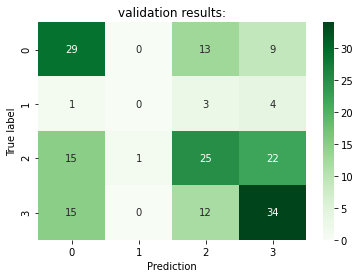

In [0]:
train_and_print(model)
compute_confusion_matrix(model)

high probability: expected scab and got scab


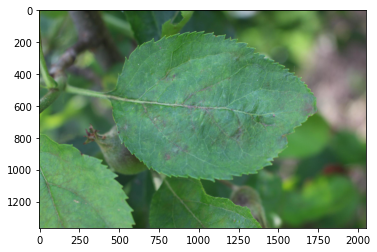

high probability: expected rust and got scab


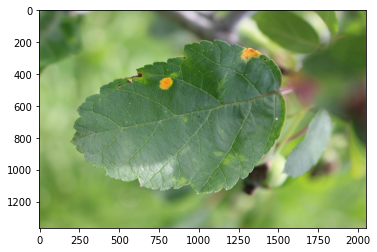

high probability: expected healthy and got healthy


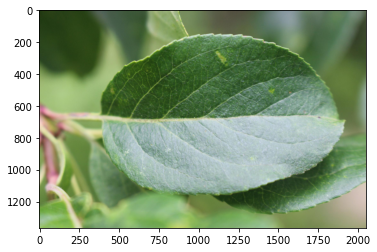

low probability: expected healthy and got scab


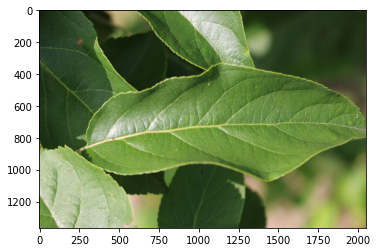

low probability: expected rust and got rust


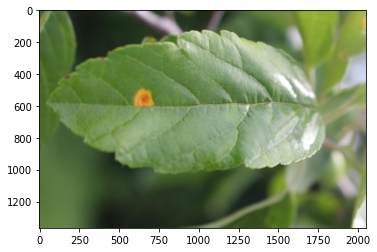

low probability: expected scab and got scab


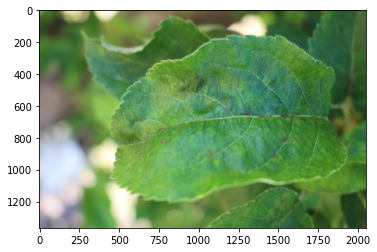

In [0]:
prediction_on_sample(model,validation_generator)

We see when looking at images classified wrong that weird angles of leaves and patterns of sunlight on them can cause it to be mislabeled. Also, some leaves contain dust or mud on them which causes the models to classify them as diseased leaves. 

Conclusion - we see that we need the model to better understand different angles and shapes of leaves. This will be addressed in our augmentation startegy.

# 2.c
We can see that while the model is copmlex enough to overfit, it does not generalize well. In fact, we cannot draw any meaningfull conclusions form the confusion matrix we have received.

To enhance the model generalization, we can use the following:
1. Augment the data, so there are more data points our model sees.
2. Use Normalization.
3. Finetune Dropout layers.

First, lets employ data augmentation:

In [6]:
batch_size=32
datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=False,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.7, 1.3]
)

train_generator = datagen.flow_from_dataframe(
    Train, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    class_mode='categorical',

    batch_size=batch_size
)
validation_generator = datagen.flow_from_dataframe(
    Validation, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    class_mode='categorical',
    batch_size=batch_size
)

Found 1638 validated image filenames belonging to 4 classes.
Found 183 validated image filenames belonging to 4 classes.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 32)      9248

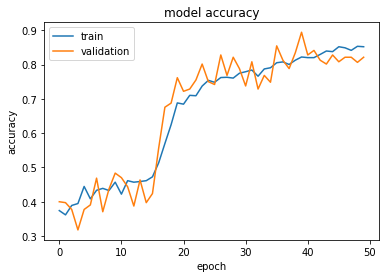

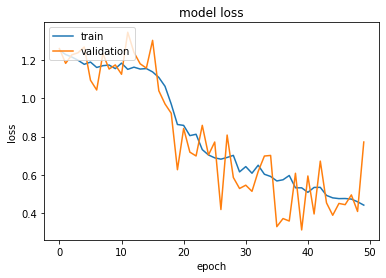

Found 183 validated image filenames belonging to 4 classes.
model accuracy on test set is: 85.79%
high probability: expected healthy and got rust


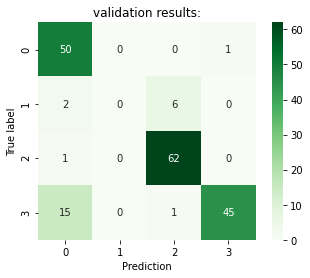

high probability: expected rust and got rust


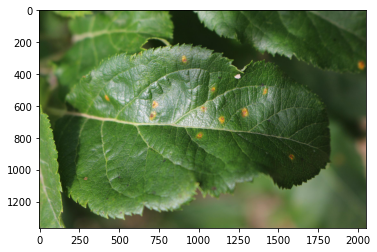

high probability: expected scab and got rust


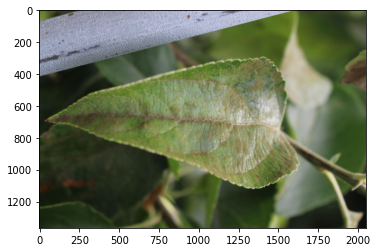

low probability: expected healthy and got healthy


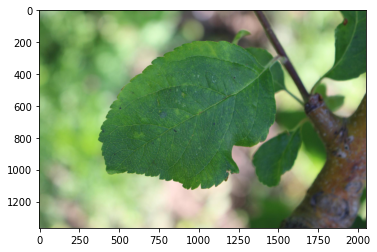

low probability: expected rust and got healthy


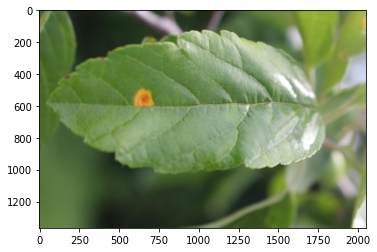

low probability: expected rust and got healthy


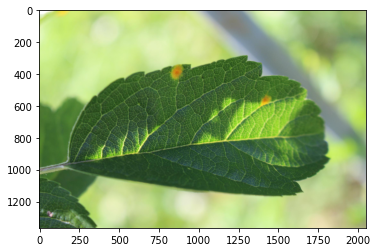

In [7]:
inp = Input((224,224,3))
x = Conv2D(16,(3,3),activation='relu',)(inp)
x = Conv2D(16,(3,3),activation='relu')(x)
x = Dropout(0.1)(x)
x = MaxPool2D()(x)
x = Conv2D(32,(3,3),activation='relu')(x)
x = Conv2D(32,(3,3),activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(4,activation='softmax')(x)

model = Model(inputs=inp,outputs=x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


train_and_print(model, 50)
compute_confusion_matrix(model)
prediction_on_sample(model,validation_generator)

We can see that nearly 2/3 of the errors are for pictures that have scab, but are classified by the model as healthy.

Perhaps the main takeaway from the model we have trained, is the outstanding contribution of data augmentation to the model's ability to generalize well. We see an impressive improvment in performance copmared to the same architecture trained only on the given dataset.

Next, we can add Normalization:

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 220, 220, 16)      2320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 110, 110, 16)      64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 108, 32)      4640

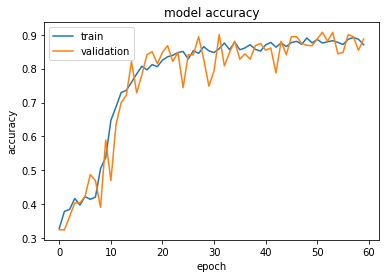

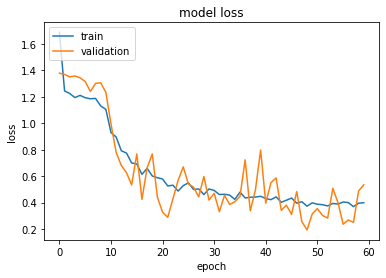

Found 183 validated image filenames belonging to 4 classes.
model accuracy on test set is: 89.07%
high probability: expected rust and got scab


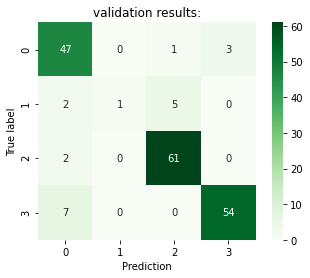

high probability: expected rust and got rust


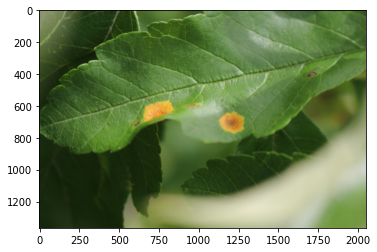

high probability: expected scab and got scab


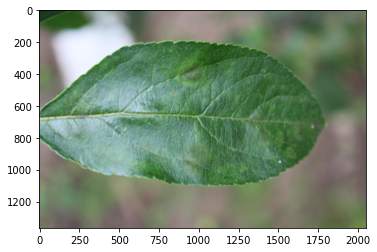

low probability: expected scab and got scab


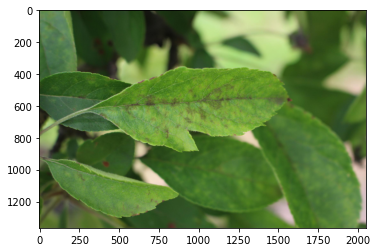

low probability: expected rust and got healthy


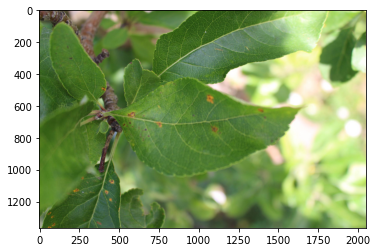

low probability: expected scab and got healthy


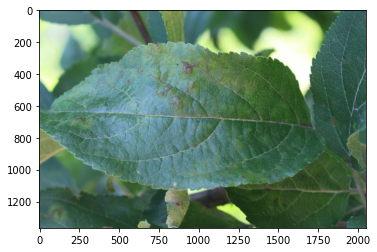

In [9]:
inp = Input((224,224,3))
x = Conv2D(16,(3,3),activation='relu')(inp)
x = Conv2D(16,(3,3),activation='relu')(x)
x = Dropout(0.1)(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(32,(3,3),activation='relu')(x)
x = Conv2D(32,(3,3),activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPool2D()(x)
# x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(4,activation='softmax')(x)

model = Model(inputs=inp,outputs=x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

train_and_print(model, epochs=60)
compute_confusion_matrix(model)
prediction_on_sample(model,validation_generator)

We can see that while this model presents superior performance to that of the previous one, still al,most half of the errors come from the mislabeling of images of leaves inflicted with scab as healthy leaves.

Moreover, copmared to the previous model, this one converged much quicker, achieving ~87% accuracy after only 27 epochs, compared to about 40 epochs.

## 3.a+b+c

creating data generators for keras models

In [0]:
batch_size=8
datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.7, 1.3]
)

train_generator = datagen.flow_from_dataframe(
    Train, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    class_mode='categorical',

    batch_size=batch_size
)
validation_generator = datagen.flow_from_dataframe(
    Validation, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    class_mode='categorical',
    batch_size=batch_size
)

Found 1638 validated image filenames belonging to 4 classes.
Found 183 validated image filenames belonging to 4 classes.


For this task we have chosen the VGG-16 model, with the ImageNet weights.

In [0]:
#get pre-trained VGG16
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in model.layers:
    layer.trainable = False

#build model from pre-trained VGG16
inp2 = model.input
flatten = Flatten()
new_layer1 = Dense(128, activation='relu')
new_layer2 = Dense(4, activation='softmax')
out2 = new_layer2(new_layer1(flatten(model.output)))
model2 = Model(inp2, out2)
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

training the model

Epoch 1/10
204/204 [==============================] - 92s 453ms/step - loss: 1.4655 - accuracy: 0.4521 - val_loss: 1.0747 - val_accuracy: 0.4432
Epoch 2/10
204/204 [==============================] - 95s 467ms/step - loss: 1.1037 - accuracy: 0.5067 - val_loss: 0.7525 - val_accuracy: 0.4629
Epoch 3/10
204/204 [==============================] - 94s 463ms/step - loss: 1.0111 - accuracy: 0.5687 - val_loss: 0.9718 - val_accuracy: 0.5486
Epoch 4/10
204/204 [==============================] - 94s 459ms/step - loss: 0.9651 - accuracy: 0.5963 - val_loss: 1.1861 - val_accuracy: 0.5714
Epoch 5/10
204/204 [==============================] - 93s 456ms/step - loss: 0.9752 - accuracy: 0.6074 - val_loss: 0.6891 - val_accuracy: 0.5371
Epoch 6/10
204/204 [==============================] - 93s 454ms/step - loss: 0.9461 - accuracy: 0.6160 - val_loss: 0.4460 - val_accuracy: 0.5886
Epoch 7/10
204/204 [==============================] - 92s 452ms/step - loss: 0.9223 - accuracy: 0.6313 - val_loss: 1.6401 - val_ac

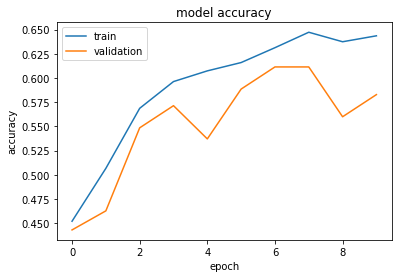

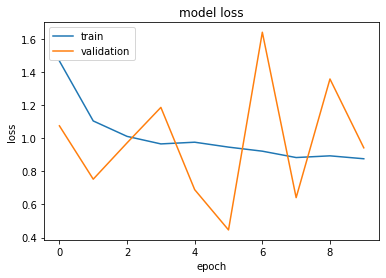

Found 183 validated image filenames belonging to 4 classes.
model accuracy on test set is: 59.56%
Epoch 1/10
204/204 [==============================] - 93s 456ms/step - loss: 0.7210 - accuracy: 0.7337 - val_loss: 0.4727 - val_accuracy: 0.7670
Epoch 2/10
204/204 [==============================] - 95s 467ms/step - loss: 0.4903 - accuracy: 0.8282 - val_loss: 1.0579 - val_accuracy: 0.8514
Epoch 3/10
204/204 [==============================] - 95s 466ms/step - loss: 0.4096 - accuracy: 0.8748 - val_loss: 0.9072 - val_accuracy: 0.8000
Epoch 4/10
204/204 [==============================] - 96s 469ms/step - loss: 0.3375 - accuracy: 0.8957 - val_loss: 0.4746 - val_accuracy: 0.8857
Epoch 5/10
204/204 [==============================] - 95s 467ms/step - loss: 0.2998 - accuracy: 0.9018 - val_loss: 0.1874 - val_accuracy: 0.8686
Epoch 6/10
204/204 [==============================] - 94s 459ms/step - loss: 0.2710 - accuracy: 0.9031 - val_loss: 0.2932 - val_accuracy: 0.8914
Epoch 7/10
204/204 [============

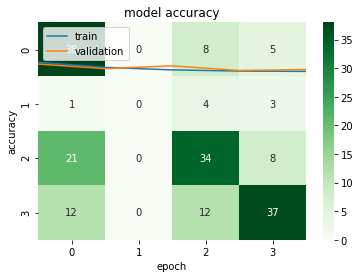

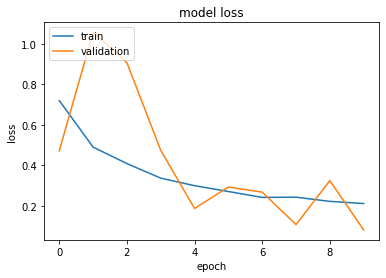

Found 183 validated image filenames belonging to 4 classes.
model accuracy on test set is: 90.71%


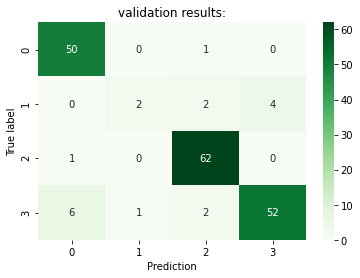

In [0]:
#run model
train_and_print(model2)
compute_confusion_matrix(model2)

#more training with all of the layers including vgg16 layers
for layer in model.layers:
    layer.trainable = True
model2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.00001),metrics=['accuracy'])
train_and_print(model2)
compute_confusion_matrix(model2)

## 3.d

In [0]:
model2.layers.pop() # pop the classifying node

In [0]:
train_generator = datagen.flow_from_dataframe(
    Train, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    class_mode='categorical',
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    shuffle=False,
    batch_size=batch_size
)
validation_generator = datagen.flow_from_dataframe(
    Validation, 
    x_col='X',
    y_col= 'y',
    target_size=(224,224),
    class_mode='categorical',
    classes=['healthy', 'multiple_diseases', 'rust', 'scab'],
    shuffle=False,
    batch_size=batch_size
)

Found 1638 validated image filenames belonging to 4 classes.
Found 183 validated image filenames belonging to 4 classes.


model accuracy on validation set is: 90.7103825136612%


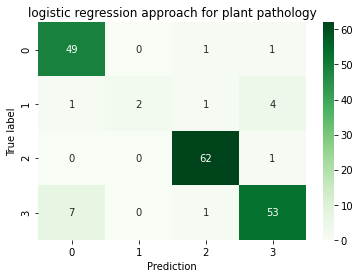

In [0]:
#get features 
train_by_keras_features = model2.predict(train_generator)

#build and train model
lrc = LogisticRegression(solver='lbfgs',multi_class='auto')
lrc.fit(train_by_keras_features,y_train)

#evalute model
res_by_keras_features = model2.predict(validation_generator)
preds = lrc.predict(res_by_keras_features)
pred_cat = preds

#plot results
print('model accuracy on validation set is: {}%'.format(accuracy_score(y_val,pred_cat)*100))
sns.heatmap(confusion_matrix(y_val,pred_cat),cmap='Greens',annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('logistic regression approach for plant pathology')
plt.show()

